# Annual TS and SST correlation

In [1]:
%pylab inline
import os
import downglacier.sandbox.tcd_utils as utils
import downglacier.graphics as dgplot
import seaborn as sns
import pandas as pd
from datetime import datetime as dt
pal = sns.color_palette('pastel')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
lag=3

In [3]:
wd = utils.run_standard(run=False)
odir = os.path.join(wd, 'output')

### Data

In [4]:
dfd = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_ts.csv'), index_col=0, 
                               parse_dates= {"time" : [0]}).loc[dt(1979,10,1):dt(2013,9,1)]
dfi = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_info.csv'), index_col=0).T
# filter keys fir height
dfi.columns = [s.split('_')[0] + '_' + s.split('_')[2] for s in dfi.columns]
dfd.columns = [s.split('_')[0] + '_' + s.split('_')[2] for s in dfd.columns]
varkeys = dfd.columns

### RMSE

In [5]:
dfe = dfd * 0.
for varn in dfd.columns:
    err = dfi.loc['rmse', varn]
    if varn in ['mbtotfromsum_diag', 'mbtot_ds']: 
        err = (250 + err) / sqrt(2)
    dfe[varn].iloc[:] = err

### SST lag3!

In [6]:
dfsst = utils.get_enso_df(lag=lag)
dfd['yi'] = dfsst['yi']
dfd['sst'] = dfsst['sst']

### Composites

In [7]:
ydf = dfd.groupby('yi').mean()
ydf['mbtotfromsum_diag'] = dfd.groupby('yi').sum()['mbtotfromsum_diag']
# ydf['yi'] = ydf.index
# sns.lmplot("yi", "mbtotfromsum_diag", ydf, ci=68);

## Plot

In [8]:
bp = utils.get_sst_baseplot(lag=lag)

In [9]:
data = ydf['mbtotfromsum_diag'].values
err = 12 * dfe['mbtotfromsum_diag'].values[0] / sqrt(12)
xdata = np.arange(len(data)) * 12 + 5

In [10]:
dfe['mbtotfromsum_diag'].values[0]
td = np.random.normal(size=(12, 1000))
print(np.std(np.mean(td, axis=0)), 1 / np.sqrt(12))
print(np.std(np.sum(td, axis=0)), 12 / np.sqrt(12))

0.282295477398 0.288675134595
3.38754572877 3.46410161514


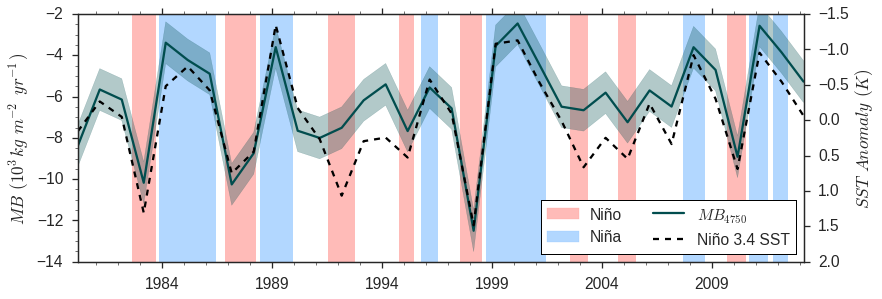

In [11]:
fig = plt.figure(figsize=(12, 4), dpi=200)
ax = fig.add_subplot(111)

ax.plot(xdata, data / 1000., color=sns.xkcd_rgb['dark teal'], label='$MB_{4750}$')
lims = ax.get_ylim()


ax.set_ylim(lims)
plt.xlim([0, bp['nx']])
import matplotlib.collections as collections
span_where = collections.BrokenBarHCollection.span_where
c = span_where(bp['tspans'], ymin=lims[0], ymax=lims[1], where=bp['isnino'], color=pal[2], alpha=0.7, linewidths=0)
ax.add_collection(c)
c = span_where(bp['tspans'], ymin=lims[0], ymax=lims[1], where=bp['isnina'], color=pal[0], alpha=0.7, linewidths=0)
ax.add_collection(c)

ax.fill_between(xdata, (data-err) / 1000., (data+err) / 1000., 
                color=sns.xkcd_rgb['dark teal'], 
                interpolate=True, alpha=0.3)



from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(bp['majorTickPos'])
ax.xaxis.set_ticks(bp['minorTickPos'], minor=True)
ax.set_xticklabels(bp['majorTickNames'])

ax2 = ax.twinx()
ax2.plot(xdata, ydf['sst'], '--', color='k', label=u'Niño 3.4 SST')
ax2.set_ylabel('$SST\, Anomaly\, (K)$')
ax2.set_ylim([2., -1.5]);

plt.subplots_adjust(left=0.08, right=0.92, top=0.96, bottom=0.1)

import matplotlib.patches as mpatches
pat1 = mpatches.Patch(color=pal[2], alpha=0.7, label=u'Niño')
pat2 = mpatches.Patch(color=pal[0], alpha=0.7, label=u'Niña')
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = 'True'

handles, labels = ax.get_legend_handles_labels()
h2, labels = ax2.get_legend_handles_labels()
legend = plt.legend(handles=[pat1,pat2]+handles+h2, loc='lower right', ncol=2)

frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1)

ax.xaxis.grid(False)
ax.set_ylabel(u'$MB\, (10^{3} kg\, m^{-2}\, yr^{-1})$')
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_08.pdf'))

### Bootstrapping $r^{2}$

In [12]:
nb = 10000 # number or realizations
r2s = np.zeros(nb)
for i in np.arange(nb):
    r2s[i] = np.corrcoef(ydf['sst'], data + err * np.random.randn(len(data)))[0,1]

print('No error cor: {:.2f}'.format(np.corrcoef(ydf['sst'], data)[0,1]**2))
print('With error cor: {:.2f} pm {:.2f}'.format(np.mean(r2s**2), np.std(r2s**2)))

import scipy.stats
r2m = np.corrcoef(ydf['sst'], data)[0,1]**2
df = len(data) - 2
t = np.sqrt(r2m) / np.sqrt((1. - r2m) / df)
p_e = scipy.stats.t.sf(np.abs(t), df) * 2  # error probability (two tailed)
print('pval no error: {:.9f}'.format(p_e))

r2m = np.mean(r2s**2)
df = len(data) - 2
t = np.sqrt(r2m) / np.sqrt((1. - r2m) / df)
p_e = scipy.stats.t.sf(np.abs(t), df) * 2  # error probability (two tailed)
print('pval error: {:.9f}'.format(p_e))

No error cor: 0.80
With error cor: 0.67 pm 0.06
pval no error: 0.000000000
pval error: 0.000000003


### Other vars

In [14]:
ydf.columns

Index(['airtemp_ds', 'lwin_ds', 'lwnet_ds', 'lwnetsum_diag', 'lwout_ds',
       'mbspec_ds', 'mbtot_ds', 'mbtotfromcfnet_diag', 'mbtotfromcfsum_diag',
       'mbtotfromnet_diag', 'mbtotfromsum_diag', 'meltmass_ds',
       'meltmassfromnet_diag', 'meltmassfromnetcf_diag',
       'meltmassfromsum_diag', 'meltmassfromsumcf_diag', 'prcpsol_ds',
       'prcpsolclip_diag', 'prcptot_ds', 'prcptotclip_diag', 'qc_ds', 'ql_ds',
       'qm_ds', 'qmfromnet_diag', 'qmfromsum_diag', 'qps_ds', 'qs_ds',
       'submass_diag', 'submass_ds', 'submasscf_diag', 'subsurfmass_ds',
       'swin_ds', 'swnet_ds', 'swnetsum_diag', 'swout_ds', 'vp_ds', 'ws_ds',
       'sst'],
      dtype='object')

In [16]:
import scipy.stats
r2m = np.corrcoef(ydf['sst'], ydf['prcpsolclip_diag'])[0,1]**2
df = len(data) - 2
t = np.sqrt(r2m) / np.sqrt((1. - r2m) / df)
p_e = scipy.stats.t.sf(np.abs(t), df) * 2  # error probability (two tailed)
print('No error cor: {:.2f}'.format(r2m))
print('pval no error: {:.9f}'.format(p_e))

No error cor: 0.75
pval no error: 0.000000000


In [17]:
import scipy.stats
r2m = np.corrcoef(ydf['sst'], ydf['prcptotclip_diag'])[0,1]**2
df = len(data) - 2
t = np.sqrt(r2m) / np.sqrt((1. - r2m) / df)
p_e = scipy.stats.t.sf(np.abs(t), df) * 2  # error probability (two tailed)
print('No error cor: {:.2f}'.format(r2m))
print('pval no error: {:.9f}'.format(p_e))

No error cor: 0.39
pval no error: 0.000077423
